## Discrete Anomaly Detection
### Corey Solitaire
`11.4.2020`

In [1]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
%matplotlib inline

## Wranle Data:

#### Acquire

In [2]:
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)

In [3]:
df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13978 entries, 0 to 3
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ip              13978 non-null  object
 1   timestamp       13978 non-null  object
 2   request_method  13978 non-null  object
 3   status          13978 non-null  int64 
 4   size            13978 non-null  int64 
 5   destination     25 non-null     object
 6   request_agent   13978 non-null  object
dtypes: int64(2), object(5)
memory usage: 873.6+ KB


#### Change Status to Object

In [5]:
df['status'] = df['status'].astype(object)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13978 entries, 0 to 3
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ip              13978 non-null  object
 1   timestamp       13978 non-null  object
 2   request_method  13978 non-null  object
 3   status          13978 non-null  object
 4   size            13978 non-null  int64 
 5   destination     25 non-null     object
 6   request_agent   13978 non-null  object
dtypes: int64(1), object(6)
memory usage: 873.6+ KB


#### Parse Datetime

In [6]:
df.timestamp = df.timestamp.str.replace(r'(\[|\])', '', regex=True)
df.timestamp= pd.to_datetime(df.timestamp.str.replace(':', ' ', 1)) 
df = df.set_index('timestamp')
df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:42+00:00,97.105.19.58,"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:44+00:00,97.105.19.58,"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:46+00:00,97.105.19.58,"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:48+00:00,97.105.19.58,"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


#### Cleanup Text

In [7]:
# Removes "" from around strings in columns
for col in ['request_method', 'request_agent', 'destination']:
    df[col] = df[col].str.replace('"', '')

# Removes the detail of the page number
df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)  
    
df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0
2019-04-16 19:34:44+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0
2019-04-16 19:34:46+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0
2019-04-16 19:34:48+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0


#### Add Variable: Converting bytes to mb

In [8]:
df['size_mb'] = [n/1024/1024 for n in df['size']]
df.head()

,ip,request_method,status,size,destination,request_agent,size_mb
timestamp,,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0,0.488753
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0,0.003396
2019-04-16 19:34:44+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0,0.486472
2019-04-16 19:34:46+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0,0.486377
2019-04-16 19:34:48+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0,0.488246


***

## Explore:

#### Value Counts by ip address

In [9]:
df.ip.value_counts(dropna=False)

97.105.19.58      11999
173.173.113.51     1059
72.181.113.170      613
72.181.105.81       246
68.201.219.223       21
24.26.242.9          21
70.121.214.34         2
52.87.230.102         2
35.175.171.137        2
52.91.30.150          1
34.207.64.242         1
54.172.14.223         1
54.145.52.184         1
45.23.250.16          1
95.31.16.121          1
34.229.70.250         1
3.92.201.136          1
95.31.18.119          1
3.88.129.158          1
97.105.15.120         1
35.174.209.2          1
52.90.165.200         1
Name: ip, dtype: int64

In [10]:
df.groupby('ip').count()

,request_method,status,size,destination,request_agent,size_mb
ip,,,,,,
173.173.113.51,1059,1059,1059,0,1059,1059
24.26.242.9,21,21,21,0,21,21
3.88.129.158,1,1,1,0,1,1
3.92.201.136,1,1,1,0,1,1
34.207.64.242,1,1,1,0,1,1
34.229.70.250,1,1,1,0,1,1
35.174.209.2,1,1,1,0,1,1
35.175.171.137,2,2,2,0,2,2
45.23.250.16,1,1,1,0,1,1


***
***Takeaway:***

`1. Six IP Addresses make the bulk of the observations (> 2 Requests)`

`2. 97.105.19.58 is observed in the greatest frequency (11,999)`

<div class="alert alert-block alert-info"><b></b>

#### Value Counts by request_method

In [11]:
df.request_method.value_counts(dropna=False)

GET /api/v1/sales HTTP/1.1                      12403
GET /api/v1/items HTTP/1.1                       1065
GET /api/v1/stores HTTP/1.1                       229
GET / HTTP/1.1                                    107
GET /documentation HTTP/1.1                       100
GET /favicon.ico HTTP/1.1                          26
GET /api/v1//api/v1/items HTTP/1.1                 11
GET /api/v1/items/api/v1/items HTTP/1.1             7
GET /api/v1/items/next_page HTTP/1.1                5
GET /api/v1/ HTTP/1.1                               4
GET /api/v1/sales/ HTTP/1.1                         3
GET /api/v1/sales/HTTP/1.1                          3
GET /api/v1/store HTTP/1.1                          3
GET /api/v1/itemsitems HTTP/1.1                     3
GET /api/v1items HTTP/1.1                           2
GET /api/v1 HTTP/1.1                                1
GET /api/V1/HiZach! HTTP/1.1                        1
GET /api/v1/helloclass! HTTP/1.1                    1
GET /api/v1/items/HTTP/1.1  

In [12]:
df.groupby('request_method').count()

,ip,status,size,destination,request_agent,size_mb
request_method,,,,,,
GET / HTTP/1.1,107,107,107,3,107,107
GET /api/V1/HiZach! HTTP/1.1,1,1,1,0,1,1
GET /api/v1 HTTP/1.1,1,1,1,0,1,1
GET /api/v1/ HTTP/1.1,4,4,4,0,4,4
GET /api/v1//api/v1/items HTTP/1.1,11,11,11,1,11,11
GET /api/v1//api/v1/items/next_page HTTP/1.1,1,1,1,0,1,1
GET /api/v1/I_DIDNT_DO_IT!!!! HTTP/1.1,1,1,1,0,1,1
GET /api/v1/helloclass! HTTP/1.1,1,1,1,0,1,1
GET /api/v1/items HTTP/1.1,1065,1065,1065,0,1065,1065


***
***Takeaway:***

`1. Most popular end_points were sales, items, and stores`

`2. Less then 1 % of hits visisted doc`

<div class="alert alert-block alert-info"><b></b>

#### Value Counts by status

In [13]:
df.status.value_counts(dropna=False)

200    13960
499       16
301        2
Name: status, dtype: int64

In [14]:
df.groupby('status').count()

,ip,request_method,size,destination,request_agent,size_mb
status,,,,,,
200,13960,13960,13960,25,13960,13960
301,2,2,2,0,2,2
499,16,16,16,0,16,16


***
***Takeaway:***

`1. Most requests were ok and were executed`

<div class="alert alert-block alert-info"><b></b>

#### Value Counts by destination

In [15]:
df.destination.value_counts(dropna=False)

NaN                                                             13953
https://python.zach.lol/                                            4
https://ds.codeup.com/8.3_Acquire/                                  3
https://python.zach.lol/api/v1/                                     2
https://python.zach.lol/api/v1/stores?page=1                        2
https://python.zach.lol/api/V1/HiZach!                              1
https://python.zach.lol/api/v1/stores?page=999                      1
https://python.zach.lol/api/v1/I_DIDNT_DO_IT!!!!                    1
https://python.zach.lol/api/v1/items                                1
https://python.zach.lol/api/v1//api/v1/items/next_page              1
https://python.zach.lol/api/v1/stores?page=2                        1
https://python.zach.lol/api/v1//api/v1/items                        1
https://python.zach.lol/api/v1/stores?page=0                        1
http://localhost:8889/notebooks/timeseries_acquisition.ipynb        1
https://python.zach.

In [16]:
df.groupby('destination').count()

,ip,request_method,status,size,request_agent,size_mb
destination,,,,,,
http://localhost:8888/notebooks/acquire.ipynb,1,1,1,1,1,1
http://localhost:8889/notebooks/timeseries_acquisition.ipynb,1,1,1,1,1,1
https://ds.codeup.com/8.3_Acquire/,3,3,3,3,3,3
https://python.zach.lol/,4,4,4,4,4,4
https://python.zach.lol/api/V1/HiZach!,1,1,1,1,1,1
https://python.zach.lol/api/v1/,2,2,2,2,2,2
https://python.zach.lol/api/v1//api/v1/items,1,1,1,1,1,1
https://python.zach.lol/api/v1//api/v1/items/next_page,1,1,1,1,1,1
https://python.zach.lol/api/v1//api/v1/items?page=2,1,1,1,1,1,1


***
***Takeaway:***

`1. The majority of these request originated outside of the local host`

<div class="alert alert-block alert-info"><b></b>

#### Value Counts by request_agent

In [17]:
df.request_agent.value_counts(dropna=False)

python-requests/2.21.0                                                                                                       12005
python-requests/2.20.1                                                                                                        1911
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36       34
Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0                                               8
Slackbot-LinkExpanding 1.0 (+https://api.slack.com/robots)                                                                       7
Slackbot 1.0 (+https://api.slack.com/robots)                                                                                     6
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36        4
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gec

In [18]:
df.groupby('request_agent').count()

,ip,request_method,status,size,destination,size_mb
request_agent,,,,,,
Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0,8,8,8,8,0,8
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/72.0.3626.121 Safari/537.36",2,2,2,2,1,2
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36",4,4,4,4,4,4
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36",34,34,34,34,20,34
Python-urllib/3.7,1,1,1,1,0,1
Slackbot 1.0 (+https://api.slack.com/robots),6,6,6,6,0,6
Slackbot-LinkExpanding 1.0 (+https://api.slack.com/robots),7,7,7,7,0,7
python-requests/2.20.1,1911,1911,1911,1911,0,1911
python-requests/2.21.0,12005,12005,12005,12005,0,12005


***
***Takeaway:***

`1. The most popular request agent was python-requests`   
`2. The second most popular was Mozilla`   
`3. The third was a slackbot`   

<div class="alert alert-block alert-info"><b></b>

## Detecting Anomalies in Discrete Variables (Finding anomalies in already existing data):

#### Prob of IP addresses.

In [19]:
ip_df = pd.DataFrame(df.ip.value_counts(dropna=False)).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_count'})

ip_df2 = pd.DataFrame(df.ip.value_counts(dropna=False)/df.ip.count()).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_proba'})

ip_df = ip_df.merge(ip_df2)
ip_df

,ip,ip_count,ip_proba
0,97.105.19.58,11999,0.858420
1,173.173.113.51,1059,0.075762
2,72.181.113.170,613,0.043855
3,72.181.105.81,246,0.017599
4,68.201.219.223,21,0.001502
5,24.26.242.9,21,0.001502
6,70.121.214.34,2,0.000143
7,52.87.230.102,2,0.000143
8,35.175.171.137,2,0.000143
9,52.91.30.150,1,0.000072


#### Visualize Probability IP Address

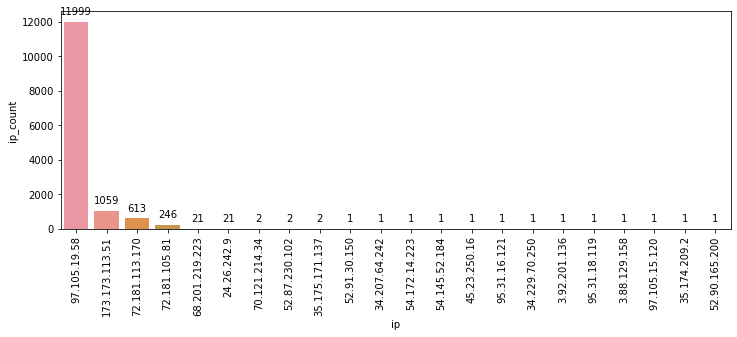

In [20]:
plt.figure(figsize=(12, 4))
splot = sns.barplot(data=ip_df, x = 'ip', y = 'ip_count', ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
    plt.xticks(rotation='vertical')

***

#### Prob of request_method

In [21]:
req_meth_df = pd.DataFrame(df.request_method.value_counts(dropna=False)).reset_index().\
                rename(index=str, columns={'index': 'request_method', 'request_method': 'request_method_count'})

req_meth_df2 = pd.DataFrame(df.request_method.value_counts(dropna=False)/df.request_method.count()).reset_index().\
                rename(index=str, columns={'index': 'request_method', 'request_method': 'request_method_proba'})

req_meth = req_meth_df.merge(req_meth_df2)
req_meth

,request_method,request_method_count,request_method_proba
0,GET /api/v1/sales HTTP/1.1,12403,0.887323
1,GET /api/v1/items HTTP/1.1,1065,0.076191
2,GET /api/v1/stores HTTP/1.1,229,0.016383
3,GET / HTTP/1.1,107,0.007655
4,GET /documentation HTTP/1.1,100,0.007154
5,GET /favicon.ico HTTP/1.1,26,0.001860
6,GET /api/v1//api/v1/items HTTP/1.1,11,0.000787
7,GET /api/v1/items/api/v1/items HTTP/1.1,7,0.000501
8,GET /api/v1/items/next_page HTTP/1.1,5,0.000358
9,GET /api/v1/ HTTP/1.1,4,0.000286


#### Visualize Probability Request Method

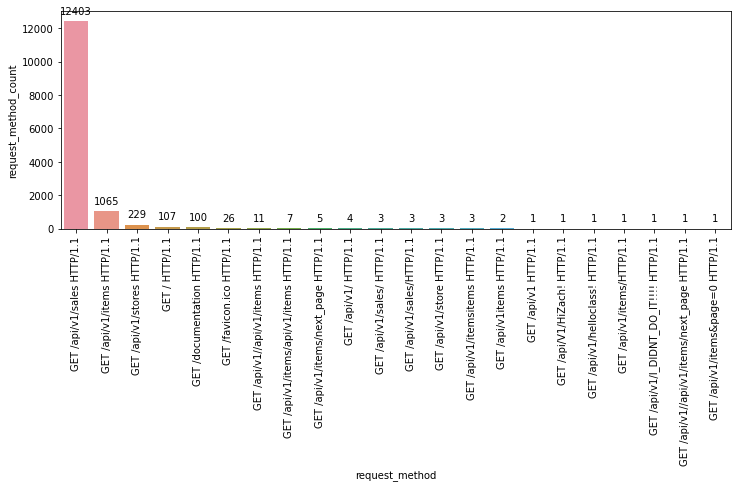

In [22]:
plt.figure(figsize=(12, 4))
splot = sns.barplot(data=req_meth, x = 'request_method', y = 'request_method_count', ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
    plt.xticks(rotation='vertical')

***

#### Prob of status

In [23]:
status_df = pd.DataFrame(df.status.value_counts(dropna=False)).reset_index().\
                rename(index=str, columns={'index': 'status', 'status': 'status_count'})

status_df2 = pd.DataFrame(df.status.value_counts(dropna=False)/df.request_method.count()).reset_index().\
                rename(index=str, columns={'index': 'status', 'status': 'status_proba'})

status = status_df.merge(status_df2)
status

,status,status_count,status_proba
0,200,13960,0.998712
1,499,16,0.001145
2,301,2,0.000143


#### Visualize Probability Status

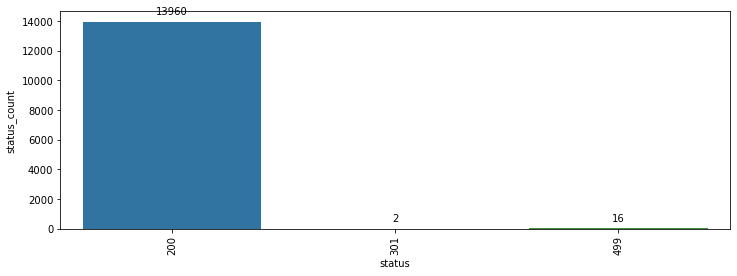

In [24]:
plt.figure(figsize=(12, 4))
splot = sns.barplot(data=status, x = 'status', y = 'status_count', ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
    plt.xticks(rotation='vertical')

***

#### Prob of destination

In [25]:
dest_df = pd.DataFrame(df.destination.value_counts(dropna=False)).reset_index().\
                rename(index=str, columns={'index': 'destination', 'destination': 'destination_count'})

dest_df2 = pd.DataFrame(df.destination.value_counts(dropna=False)/df.request_method.count()).reset_index().\
                rename(index=str, columns={'index': 'destination', 'destination': 'destination_proba'})

dest = dest_df.merge(dest_df2)
dest

,destination,destination_count,destination_proba
0,NaN,13953,0.998211
1,https://python.zach.lol/,4,0.000286
2,https://ds.codeup.com/8.3_Acquire/,3,0.000215
3,https://python.zach.lol/api/v1/,2,0.000143
4,https://python.zach.lol/api/v1/stores?page=1,2,0.000143
5,https://python.zach.lol/api/V1/HiZach!,1,0.000072
6,https://python.zach.lol/api/v1/stores?page=999,1,0.000072
7,https://python.zach.lol/api/v1/I_DIDNT_DO_IT!!!!,1,0.000072
8,https://python.zach.lol/api/v1/items,1,0.000072
9,https://python.zach.lol/api/v1//api/v1/items/n...,1,0.000072


#### Visualize Probability Destination

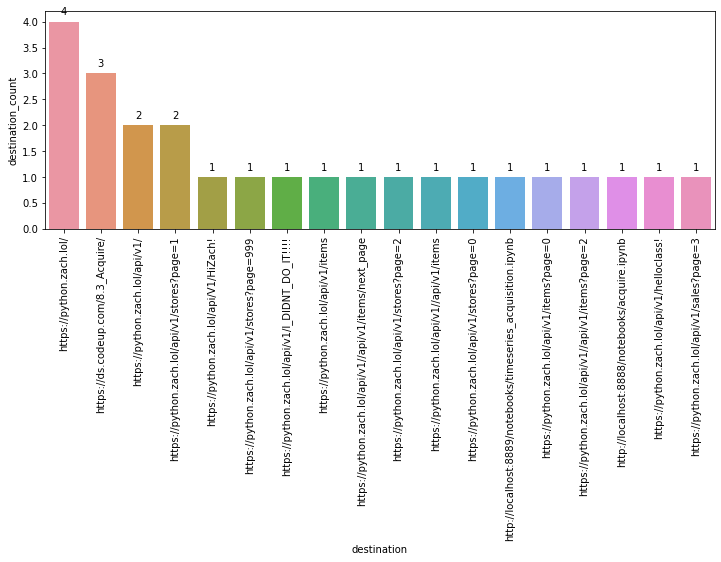

In [26]:
plt.figure(figsize=(12, 4))
splot = sns.barplot(data=dest, x = 'destination', y = 'destination_count', ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
    plt.xticks(rotation='vertical')

***

#### Prob of request agent

In [27]:
agent_df = pd.DataFrame(df.request_agent.value_counts(dropna=False)).reset_index().\
                rename(index=str, columns={'index': 'request_agent', 'request_agent': 'request_agent_count'})

agent_df2 = pd.DataFrame(df.request_agent.value_counts(dropna=False)/df.request_method.count()).reset_index().\
                rename(index=str, columns={'index': 'request_agent', 'request_agent': 'request_agent_proba'})

agent = agent_df.merge(agent_df2)
agent

,request_agent,request_agent_count,request_agent_proba
0,python-requests/2.21.0,12005,0.858850
1,python-requests/2.20.1,1911,0.136715
2,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,34,0.002432
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,8,0.000572
4,Slackbot-LinkExpanding 1.0 (+https://api.slack...,7,0.000501
5,Slackbot 1.0 (+https://api.slack.com/robots),6,0.000429
6,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,4,0.000286
7,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,2,0.000143
8,Python-urllib/3.7,1,0.000072


#### Visualize Probability Request Agent

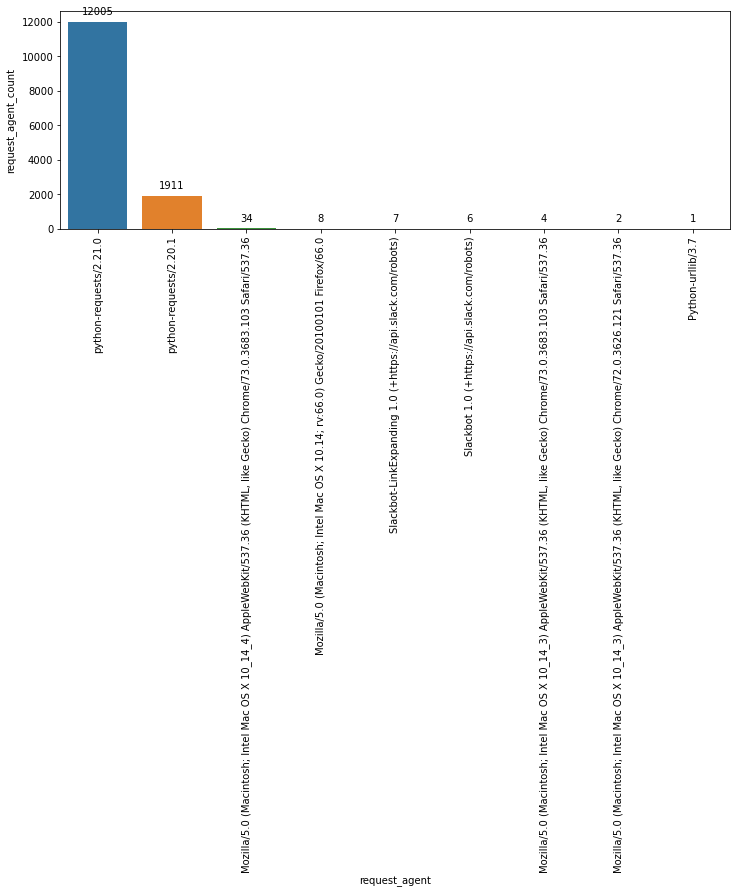

In [28]:
plt.figure(figsize=(12, 4))
splot = sns.barplot(data=agent, x = 'request_agent', y = 'request_agent_count', ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
    plt.xticks(rotation='vertical')

***

## Detecting anomalies by establishing a baseline and evaluate as new data arrives

***

#### Estabolish Baseline

In [29]:
# Work around from Adam
train = df.loc['2019-04-16 19:34:42':'2019-04-17 12:55:14']
train = train[['ip','request_method','status','size','destination','request_agent','size_mb']]

In [30]:
train.shape

(13974, 7)

#### Compute probabilities based on train sample:

In [31]:
# Probability of discrete/categorical occurence
ip_df = pd.DataFrame(train.ip.value_counts(dropna=False)/train.ip.count()).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_proba'})
method_df = pd.DataFrame(train.request_method.value_counts(dropna=False)/train.request_method.count()).reset_index().\
                rename(index=str, columns={'index': 'request_method', 'request_method': 'request_method_proba'})
status_df = pd.DataFrame(train.status.value_counts(dropna=False)/train.status.count()).reset_index().\
                rename(index=str, columns={'index': 'status', 'status': 'status_proba'})
destination_df = pd.DataFrame(train.destination.value_counts(dropna=False)/train.destination.count()).reset_index().\
                rename(index=str, columns={'index': 'destination', 'destination': 'destination_proba'})
agent_df = pd.DataFrame(train.request_agent.value_counts(dropna=False)/train.request_agent.count()).reset_index().\
                rename(index=str, columns={'index': 'request_agent', 'request_agent': 'request_agent_proba'})

#### Merge probabilities with all data (train + new data):

`Where the IP address is new, i.e. not seen in the training dataset, fill the probability with a value of 0.`

In [32]:
df = df.reset_index().merge(ip_df, on=['ip'], how='left').fillna(value=0).set_index('timestamp')
df = df.reset_index().merge(method_df, on=['request_method'], how='left').fillna(value=0).set_index('timestamp')
df = df.reset_index().merge(status_df, on=['status'], how='left').fillna(value=0).set_index('timestamp')
df = df.reset_index().merge(destination_df, on=['destination'], how='left').fillna(value=0).set_index('timestamp')
df = df.reset_index().merge(agent_df, on=['request_agent'], how='left').fillna(value=0).set_index('timestamp')
df.head()

,ip,request_method,status,size,destination,request_agent,size_mb,ip_proba,request_method_proba,status_proba,destination_proba,request_agent_proba
timestamp,,,,,,,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,0,python-requests/2.21.0,0.488753,0.858595,0.887577,0.998855,0.0,0.858809
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,0,python-requests/2.21.0,0.003396,0.858595,0.076213,0.998855,0.0,0.858809
2019-04-16 19:34:44+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,0,python-requests/2.21.0,0.486472,0.858595,0.887577,0.998855,0.0,0.858809
2019-04-16 19:34:46+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,0,python-requests/2.21.0,0.486377,0.858595,0.887577,0.998855,0.0,0.858809
2019-04-16 19:34:48+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,0,python-requests/2.21.0,0.488246,0.858595,0.887577,0.998855,0.0,0.858809


#### Sanity Check

In [33]:
df.ip_proba.value_counts()

0.858595    11999
0.075784     1059
0.043867      613
0.017604      246
0.001503       42
0.000072       10
0.000143        6
0.000000        3
Name: ip_proba, dtype: int64

In [34]:
df.request_method_proba.value_counts()

0.887577    12403
0.076213     1065
0.016388      229
0.007657      107
0.007156      100
0.001861       26
0.000787       11
0.000215        9
0.000501        7
0.000072        6
0.000358        5
0.000286        4
0.000000        4
0.000143        2
Name: request_method_proba, dtype: int64

***

## Conditional Probabilities: Probabilities using 2 discrete variables

***

`Exploring anomalous request methods`

In [35]:
train.describe()

,size,size_mb
count,13974.000000,13974.000000
mean,449900.797338,0.429059
std,160742.535606,0.153296
min,0.000000,0.000000
25%,500637.000000,0.477445
50%,510138.000000,0.486506
75%,511291.000000,0.487605
max,513736.000000,0.489937


In [36]:
# Create new categorical feature
category = pd.cut(train.size_mb,bins=[0,0.477445,0.486506,0.487605,0.489937],labels=['very_low','low','med','high'])
train.insert(4,'data_moved',category)
train.head()

,ip,request_method,status,size,data_moved,destination,request_agent,size_mb
timestamp,,,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,high,NaN,python-requests/2.21.0,0.488753
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,very_low,NaN,python-requests/2.21.0,0.003396
2019-04-16 19:34:44+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,low,NaN,python-requests/2.21.0,0.486472
2019-04-16 19:34:46+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,low,NaN,python-requests/2.21.0,0.486377
2019-04-16 19:34:48+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,high,NaN,python-requests/2.21.0,0.488246


In [37]:
method_probs = train.groupby('request_method').size().div(len(df)) # This Works

status_given_request_method = pd.DataFrame(train.groupby(['request_method', 'data_moved']).\
                               size().div(len(train)).\
                               div(method_probs, 
                                   axis=0, 
                                   level='request_method').\
                               reset_index().\
                               rename(index=str, 
                                      columns={0: 'proba_size_mb_given_request_method'})
                              )
status_given_request_method

,request_method,data_moved,proba_size_mb_given_request_method
0,GET / HTTP/1.1,very_low,1.000286
1,GET / HTTP/1.1,low,0.000000
2,GET / HTTP/1.1,med,0.000000
3,GET / HTTP/1.1,high,0.000000
4,GET /api/V1/HiZach! HTTP/1.1,very_low,1.000286
...,...,...,...
75,GET /documentation HTTP/1.1,high,0.000000
76,GET /favicon.ico HTTP/1.1,very_low,1.000286
77,GET /favicon.ico HTTP/1.1,low,0.000000
78,GET /favicon.ico HTTP/1.1,med,0.000000


In [51]:
ip_status_count = pd.DataFrame(train.groupby(['request_method', 'data_moved'])['ip'].\
                                count().reset_index().\
                                rename(index=str, 
                                       columns={'ip_status_count': 'request_method_status_count'}))

ip_status = status_given_request_method.merge(ip_status_count)
ip_status.sort_values(by="proba_size_mb_given_request_method", ascending=False)

,request_method,data_moved,proba_size_mb_given_request_method,ip
16,GET /api/v1//api/v1/items HTTP/1.1,very_low,1.000286,11
60,GET /api/v1/store HTTP/1.1,very_low,1.000286,3
56,GET /api/v1/sales/ HTTP/1.1,very_low,1.000286,3
48,GET /api/v1/itemsitems HTTP/1.1,very_low,1.000286,3
0,GET / HTTP/1.1,very_low,1.000286,107
...,...,...,...,...
42,GET /api/v1/items/api/v1/items HTTP/1.1,med,0.000000,0
43,GET /api/v1/items/api/v1/items HTTP/1.1,high,0.000000,0
9,GET /api/v1 HTTP/1.1,low,0.000000,0
45,GET /api/v1/items/next_page HTTP/1.1,low,0.000000,0
